In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Equation: 

# $$ \frac{dx}{dt} = \lambda x$$

# == Setup ==



# Generator (regression):

<img src="generator.png" width="500">

# Discriminator (classification):

<img src="discriminator.png" width="500">

## Analytical Solutionn

In [2]:
L = -1
analytic = lambda t: np.exp(L*t)

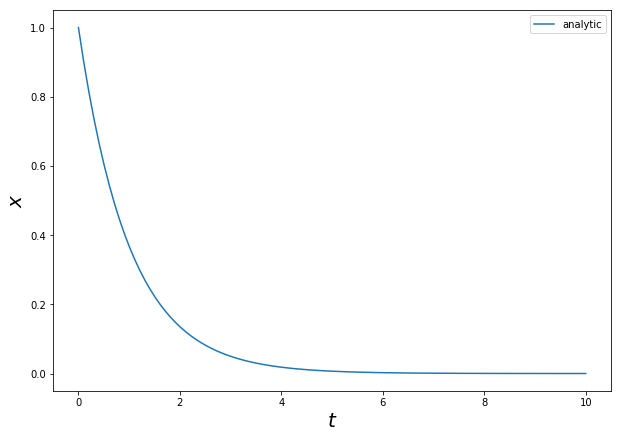

In [3]:
t = np.linspace(0,10,100)
plt.figure(figsize=(10,7))
plt.xlabel('$t$', fontsize=20)
plt.ylabel('$x$', fontsize=20)
plt.plot(t, analytic(t), '-', label='analytic')
plt.legend();

## GAN

In [4]:
import torch
import torch.nn as nn
from torch import tensor, autograd

In [5]:
class Generator(nn.Module):
    def __init__(self, n_hidden=20):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(1, n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden, n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden, 1) # regression
        )
    
    def forward(self, x):
        output = self.main(x)
        return output

class Discriminator(nn.Module):
    def __init__(self, n_hidden=20):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(1, n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden, n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden, 1),
            nn.Sigmoid() # classification
        )
    
    def forward(self, x):
        output = self.main(x)
        return output

In [60]:
def train(L, epochs, g_hidden=10, d_hidden= 10, t_low=0, t_high=10, n=100, real_label=1, fake_label=0, logging=True):
    # initialize nets
    G = Generator(n_hidden=g_hidden)
    D = Discriminator(n_hidden=d_hidden)
    
    # data (grid)
    t = torch.linspace(t_low, t_high, n, dtype=torch.float, requires_grad=True).reshape(-1,1)
    
    # optimization
    criterion = nn.BCELoss()
    optiD = torch.optim.Adam(D.parameters(), lr=0.001, betas=(0.9, 0.999))
    optiG = torch.optim.Adam(G.parameters(), lr=0.001, betas=(0.9, 0.999))
    
    # logging
    D_losses = []
    G_losses = []
    Dx_list = []
    DGz1_list = []
    DGz2_list = []
    
    for epoch in range(epochs):

        # generate L * x
        real = L * G(t)

        # compute dx/dt
        fake, = autograd.grad(real, t, grad_outputs=real.data.new(real.shape).fill_(1),
                               retain_graph=True, create_graph=True)
        
        ## ========
        ## UPDATE D
        ## ========
        
        # train with real
        D.zero_grad()
        label = torch.full((t.shape[0],), real_label).reshape(-1,1)
        output = D(real)
        errD_real = criterion(output, label)
        errD_real.backward(retain_graph=True)
        D_x = output.mean().item() # for logging
        
        # train with fake
        label.fill_(fake_label)
        output = D(fake)
        errD_fake = criterion(output, label)
        errD_fake.backward(retain_graph=True)
        D_G_z1 = output.mean().item()
        
        # step for D
        errD = errD_real + errD_fake # for logging
        optiD.step()
        
        ## ========
        ## UPDATE G
        ## ========
        
        G.zero_grad()
        label.fill_(real_label) # fake labels == real for Generator
        output = D(fake)
        errG = criterion(output, label)
        errG.backward(retain_graph=True)
        D_G_z2 = output.mean().item() # for logging
        optiG.step()
        
        ## ========
        ## Logging
        ## ======== 
        if logging:
            print('[%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                      % (epoch, epochs,
                         errD.item(), errG.item(), 
                         D_x, D_G_z1, D_G_z2))
        D_losses.append(errD.item())
        G_losses.append(errG.item())
        Dx_list.append(D_x)
        DGz1_list.append(D_G_z1)
        DGz2_list.append(D_G_z2)
        
    return G, D, G_losses, D_losses, Dx_list, DGz1_list, DGz2_list

In [35]:
def plot_loss(G_loss, D_loss, ax):
    epochs=np.arange(len(G_loss))
    ax.plot(epochs, G_loss, label='G Loss')
    ax.plot(epochs, D_loss, label='D Loss')
    ax.set_title('Loss of D and G')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend()

def plot_preds(G, t, analytic, ax):
    ax.plot(t, analytic(t), label='analytic')
    t_torch = tensor(t, dtype=torch.float, requires_grad=True).reshape(-1,1)
    pred = G(t_torch)
    ax.plot(t, pred.detach().numpy(), label='pred')
    ax.set_title('Pred and Analytic')
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    ax.legend()

In [55]:
def plot_losses_and_preds(G_loss, D_loss, G, t, analytic, figsize=(15,5)):
    fig, ax = plt.subplots(1,2,figsize=figsize)
    plot_loss(G_loss, D_loss, ax[0])
    plot_preds(G, t, analytic, ax[1])
    plt.show()

In [57]:
g_nodes = [5,10,20,30]
d_nodes = [5,10,20,30]

G_hidden = 5 | D_hidden = 5


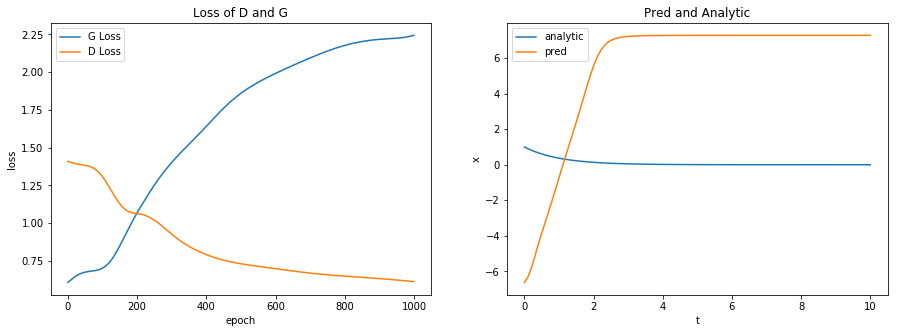

G_hidden = 5 | D_hidden = 10


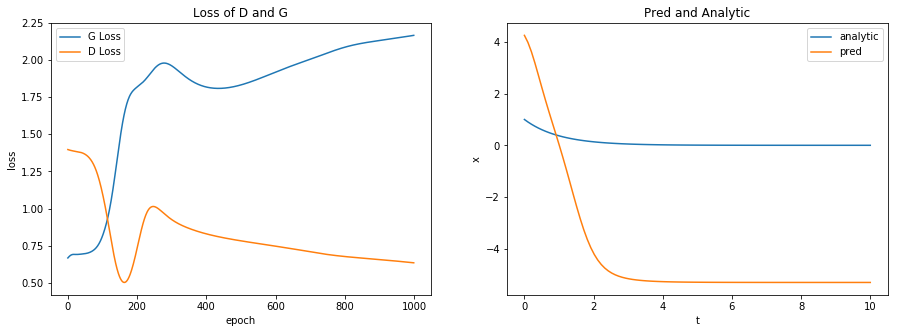

G_hidden = 5 | D_hidden = 20


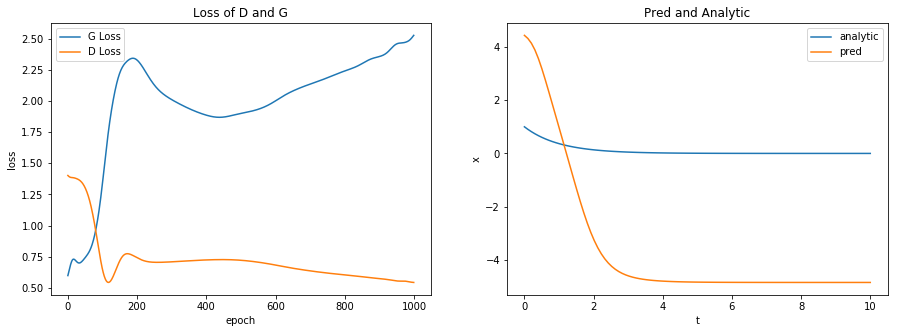

G_hidden = 5 | D_hidden = 30


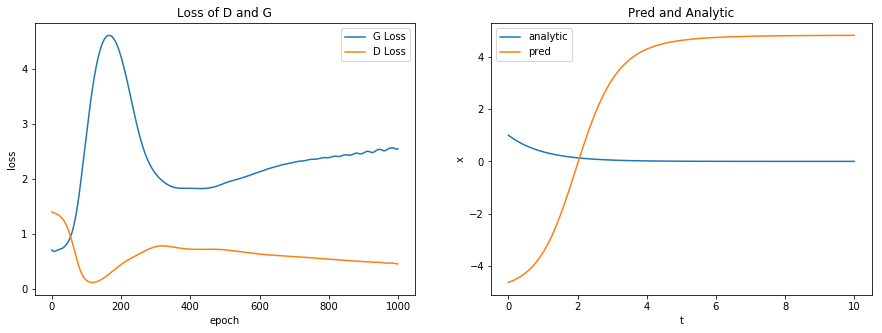

G_hidden = 10 | D_hidden = 5


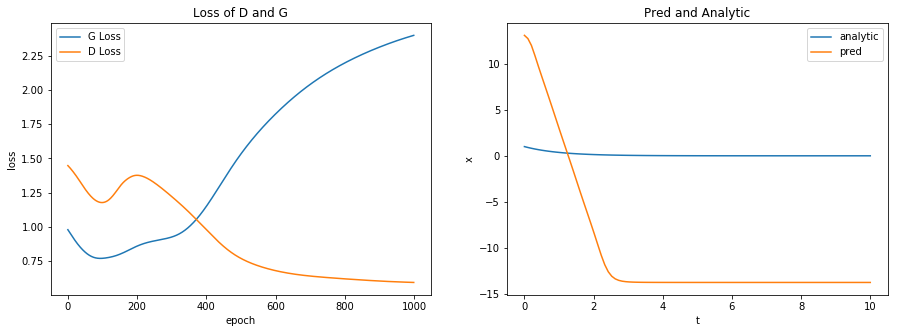

G_hidden = 10 | D_hidden = 10


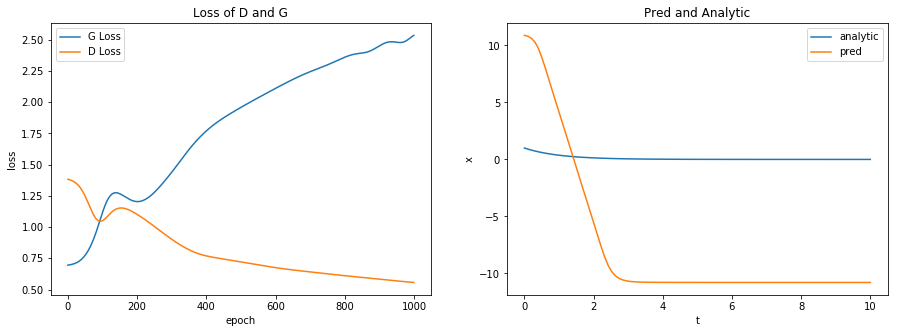

G_hidden = 10 | D_hidden = 20


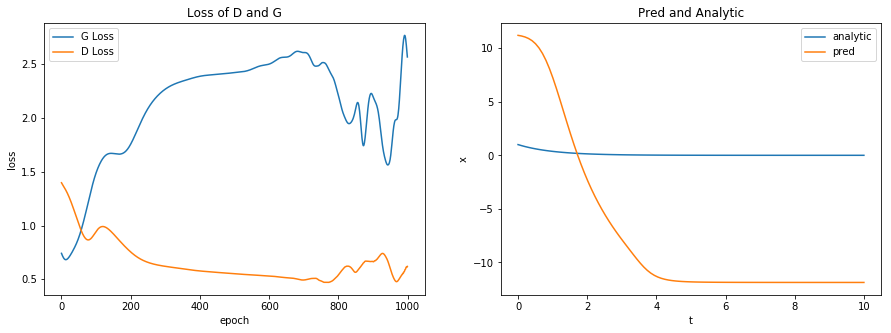

G_hidden = 10 | D_hidden = 30


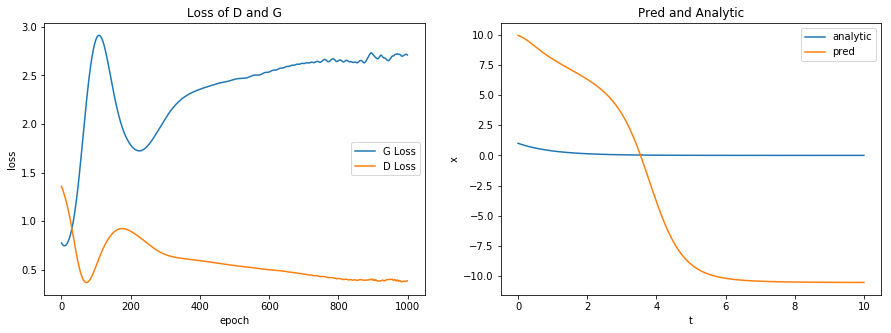

G_hidden = 20 | D_hidden = 5


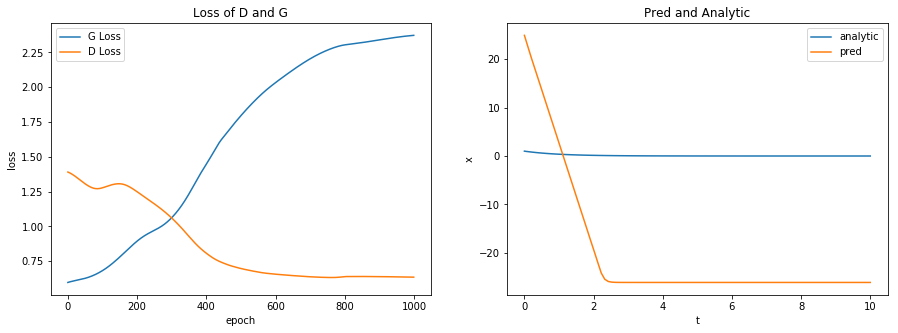

G_hidden = 20 | D_hidden = 10


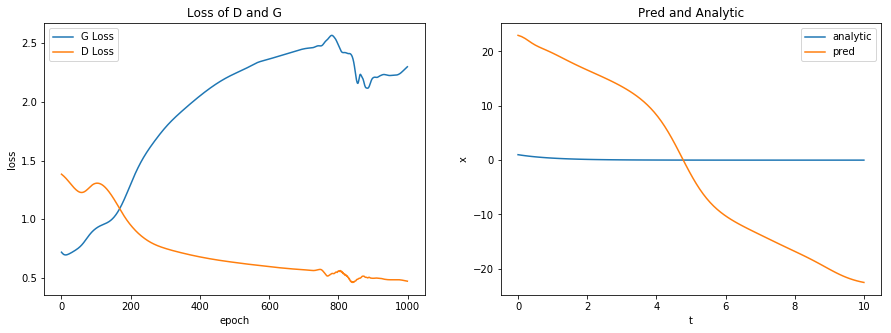

G_hidden = 20 | D_hidden = 20


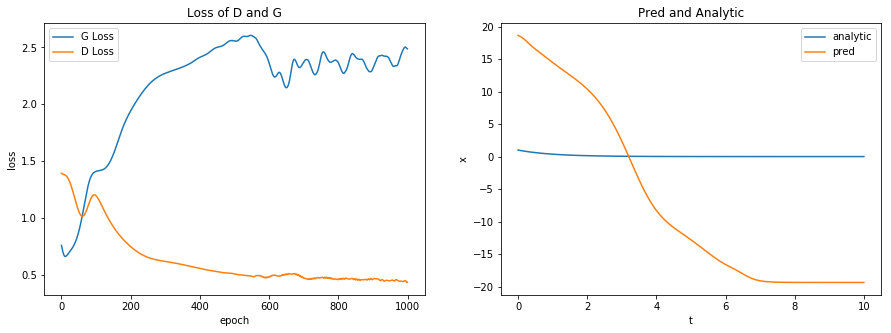

G_hidden = 20 | D_hidden = 30


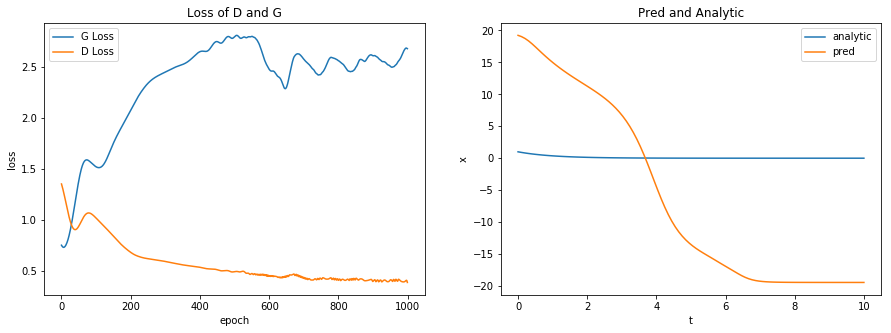

G_hidden = 30 | D_hidden = 5


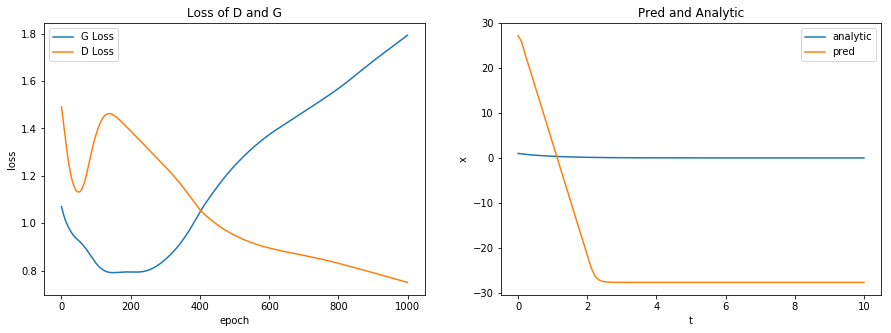

G_hidden = 30 | D_hidden = 10


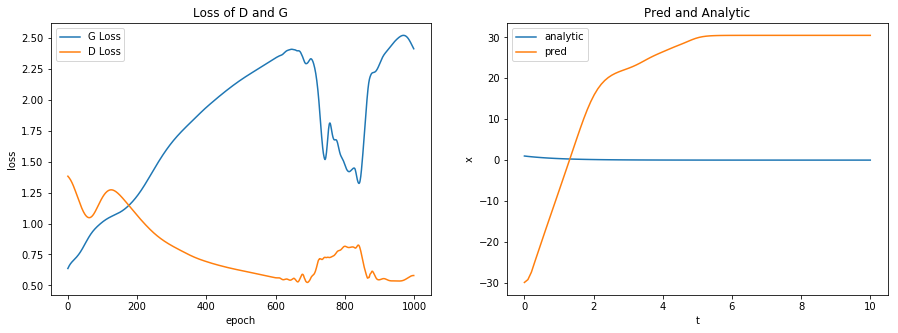

G_hidden = 30 | D_hidden = 20


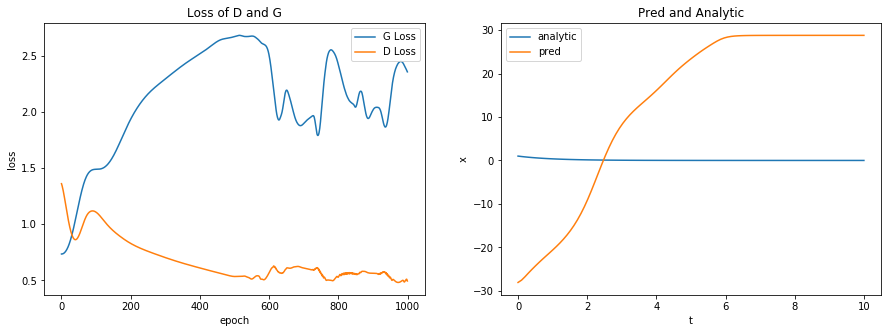

G_hidden = 30 | D_hidden = 30


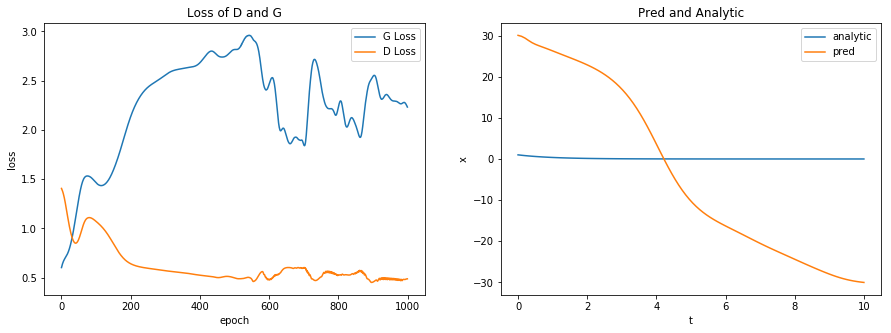

In [61]:
for g_ in g_nodes:
    for d_ in d_nodes:
        G,D,G_loss,D_loss,Dx_vals,DGz1_vals,DGz2_vals = train(L, 1000, g_hidden=g_, d_hidden=d_, logging=False)
        print('G_hidden = {} | D_hidden = {}'.format(g_, d_))
        plot_losses_and_preds(G_loss, D_loss, G, t, analytic)